<a href="https://colab.research.google.com/github/dawg-at-irya/fit-line-MCMC/blob/main/fit_line_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aim of this document: demonstrate MCMC line fitting for our previous dataset, then demonstrate it for data with intrinsic spread (a nuisance parameter).



https://emcee.readthedocs.io/en/stable/
https://arxiv.org/abs/1202.3665

What are Markov Chains? What is Markov Chain Monte Carlo?<br>
https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/Handouts/MonteCarlo_LuisAguilar.pdf<br>
https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/Lectures/Lecture19.pdf<br>

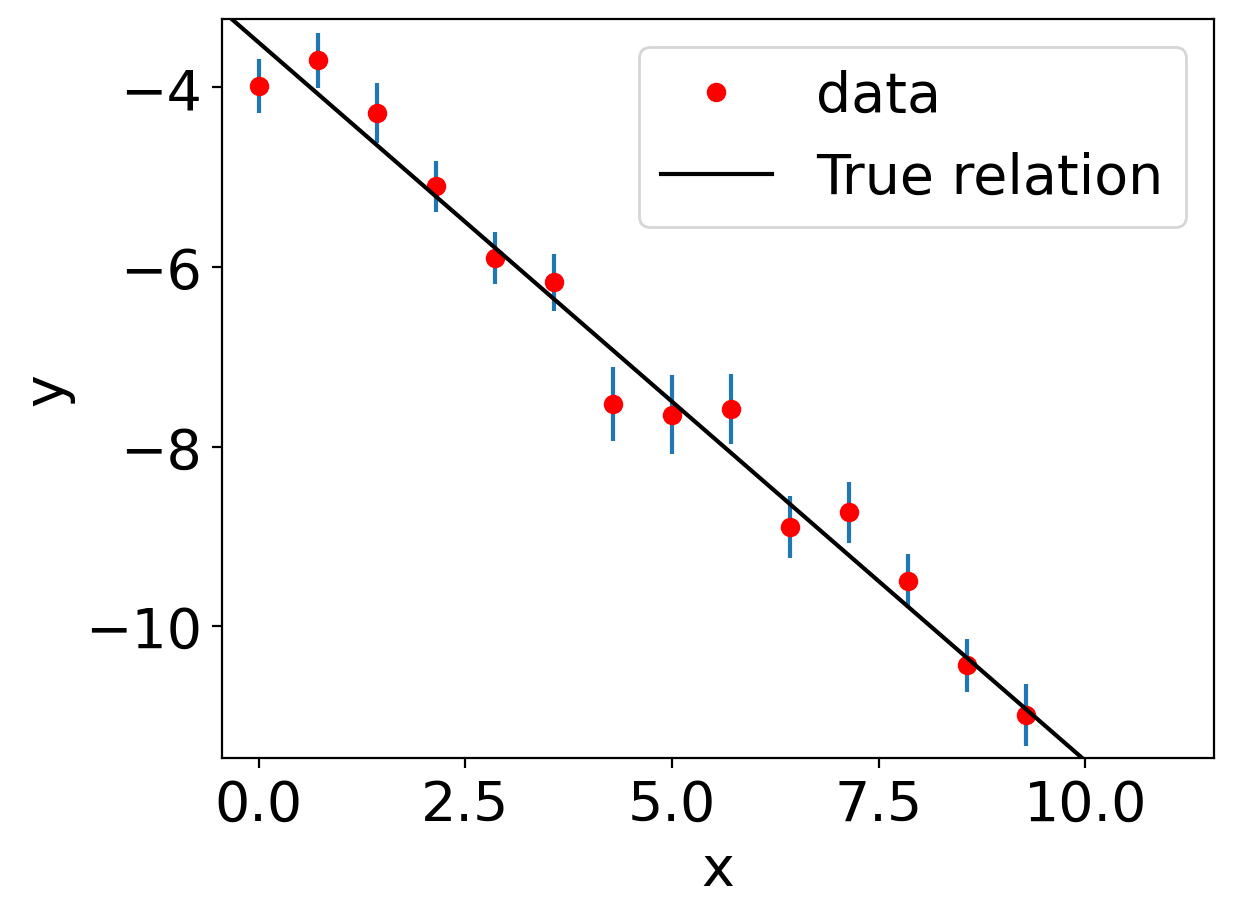

In [41]:
import numpy as np
from scipy.stats import norm

def make_data(A_true, B_true, N_data=15):
  """
    Simulate data from a straight-line model with uncertainties.
    Arguments:
      A_true, B_true: true value of intercept and slope
      N_data: number of data points to return
    Returns:
      x, y: independent and dependent variable values
      y_err: uncertainties in dependent variable
  """
  x = np.linspace(0, 10, 15)
  np.random.seed(1001) # for reproducibility
  y_err = norm.rvs(loc=0.35, scale=0.05, size=len(x))
  y = A_true + B_true * x + norm.rvs(scale=y_err)

  return x, y, y_err

def plot_data(x, y, y_err, A_true, B_true):
  """
  Plot the observations and compare them to the true relationship
  Arguments:
  x, y: independent and dependent variable values
  y_err: uncertainty in the dependent variable
  A_true, B_true: true values of the intercept and slope
  """
  plt.errorbar(x, y, yerr=y_err, linestyle='none')
  plt.plot(x, y, 'ro', label='data')
  ylim = plt.ylim()
  plt.ylim(ylim[0] * 0.9, ylim[1] * 1.1)
  xlim = np.array(plt.xlim())
  plt.xlim(xlim[0] * 0.9, xlim[1] * 1.1)
  plt.plot(xlim, A_true + B_true * xlim, 'k-', label='True relation')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(loc='best')
  plt.show()

N_data=15
A_true, B_true = -3.5, -0.8
x, y, y_err = make_data(A_true, B_true, N_data=15)
plot_data(x, y, y_err, A_true, B_true)

In [6]:
!pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.4 MB/s eta 0:00:00


In [31]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import numpy as np

In [3]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [4]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [5]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [7]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])


In [8]:
log_prob(p0[0], means, cov)

-2.596094589085444

In [9]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [10]:
sampler.run_mcmc(state, 10000);

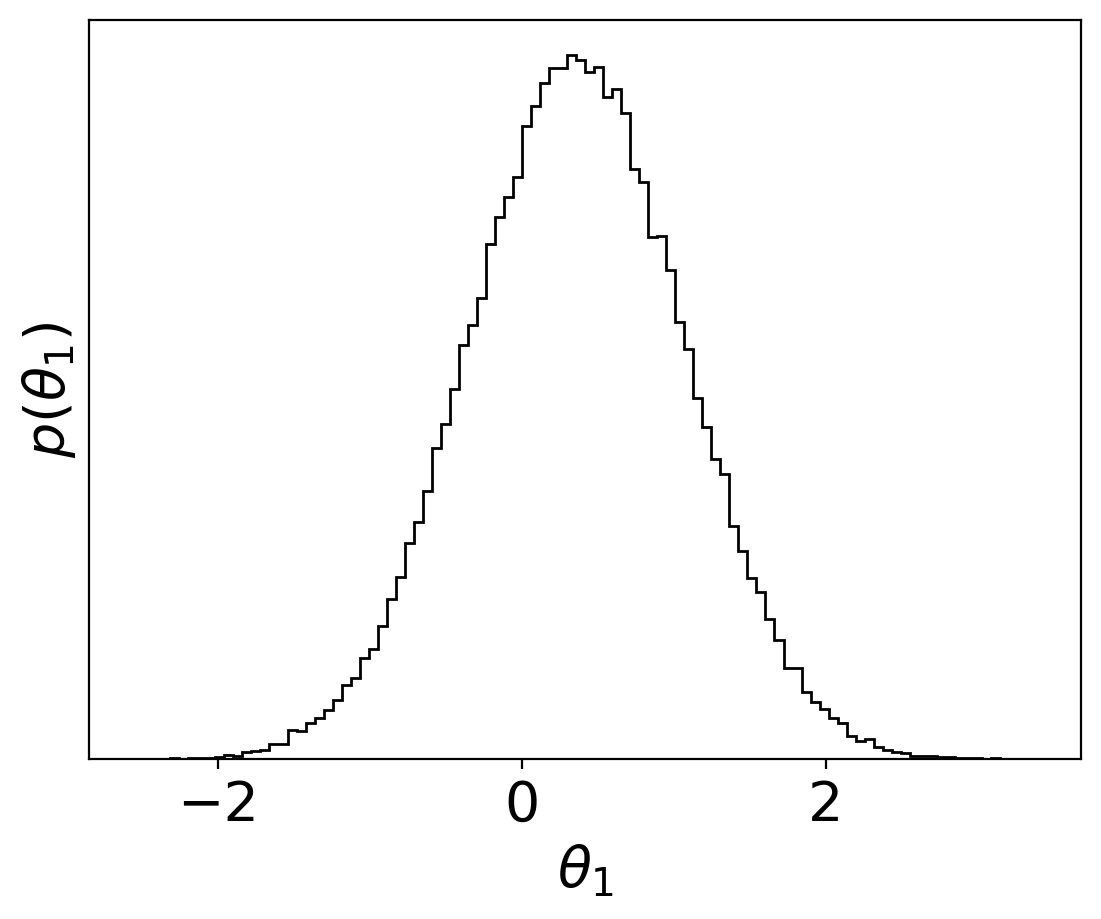

In [11]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [12]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.552


In [13]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 57.112 steps


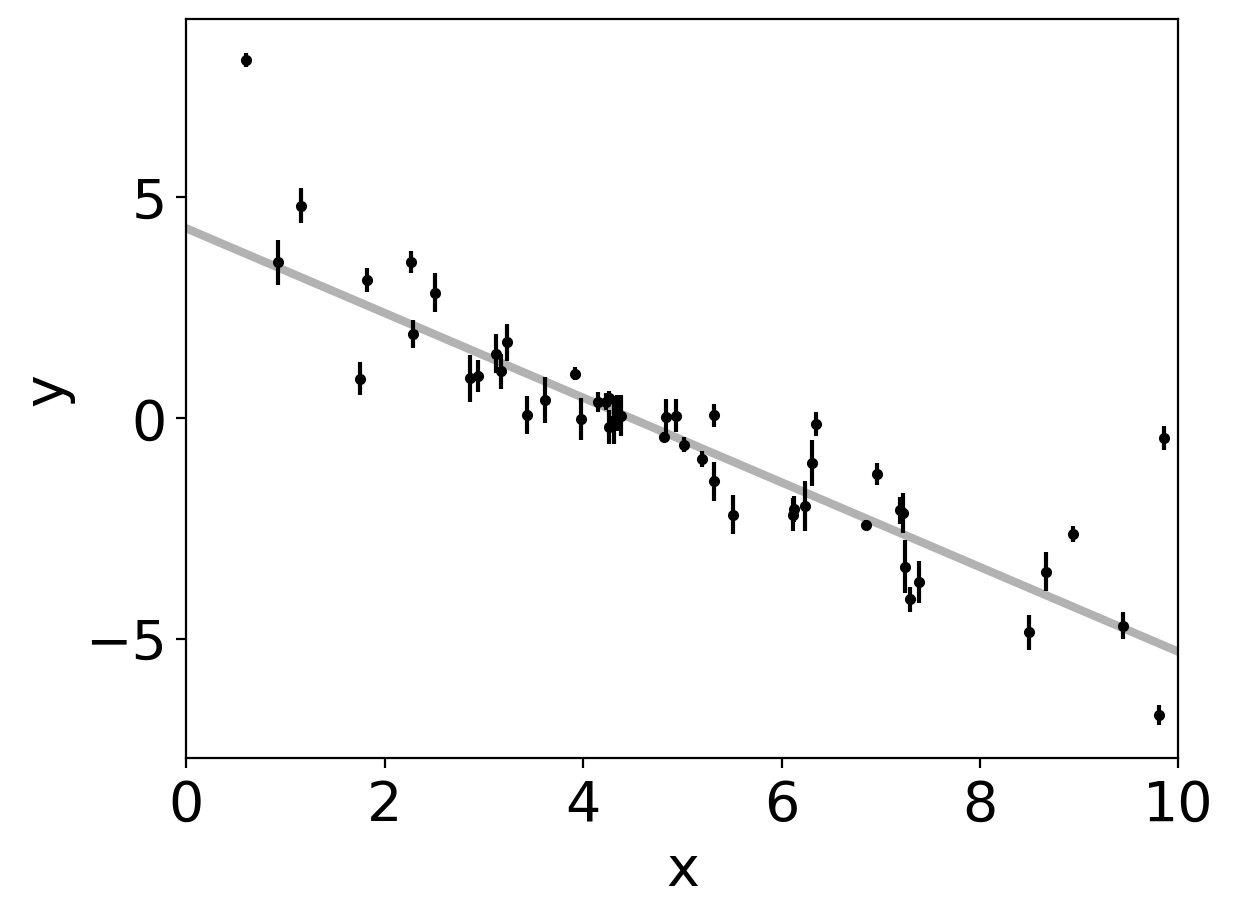

In [14]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


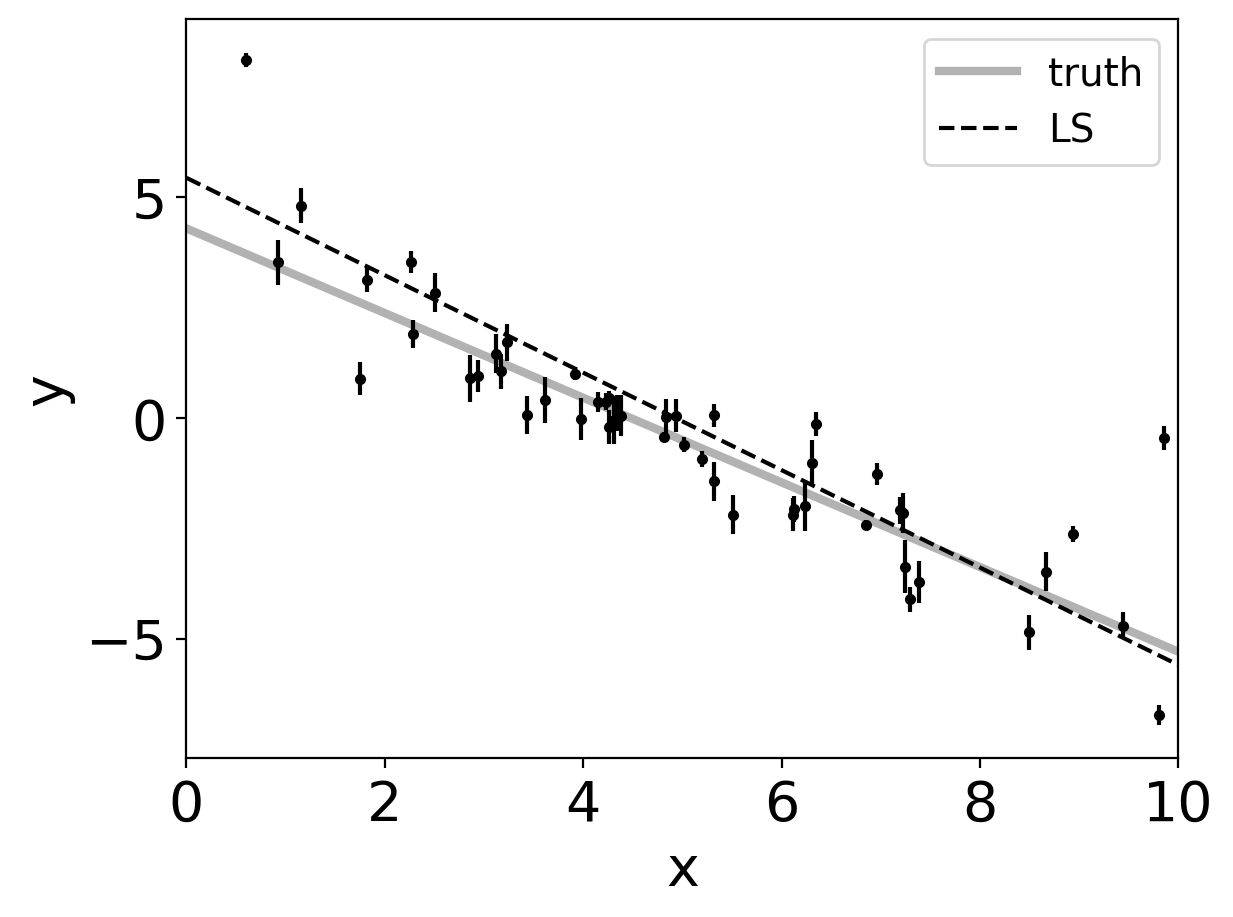

In [15]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [16]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


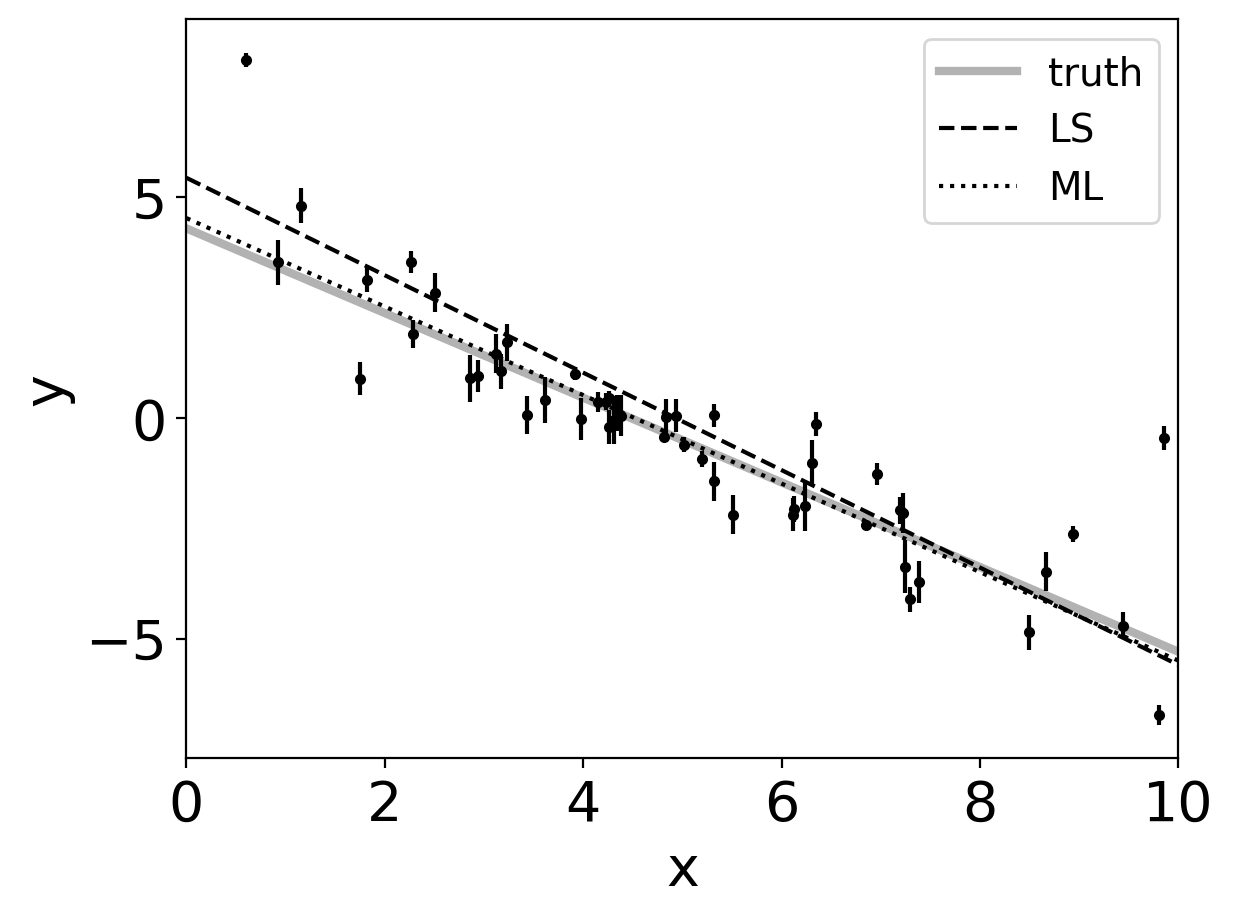

In [17]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Why use MCMC? (a) nuisance parameters can be incorporated in your model and marginalised over (b) you can estimate a posterior distribution for all useful parameters

In [18]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [19]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Walkers are initialised in a tiny Gaussian ball around the ML result

In [20]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 619.14it/s]


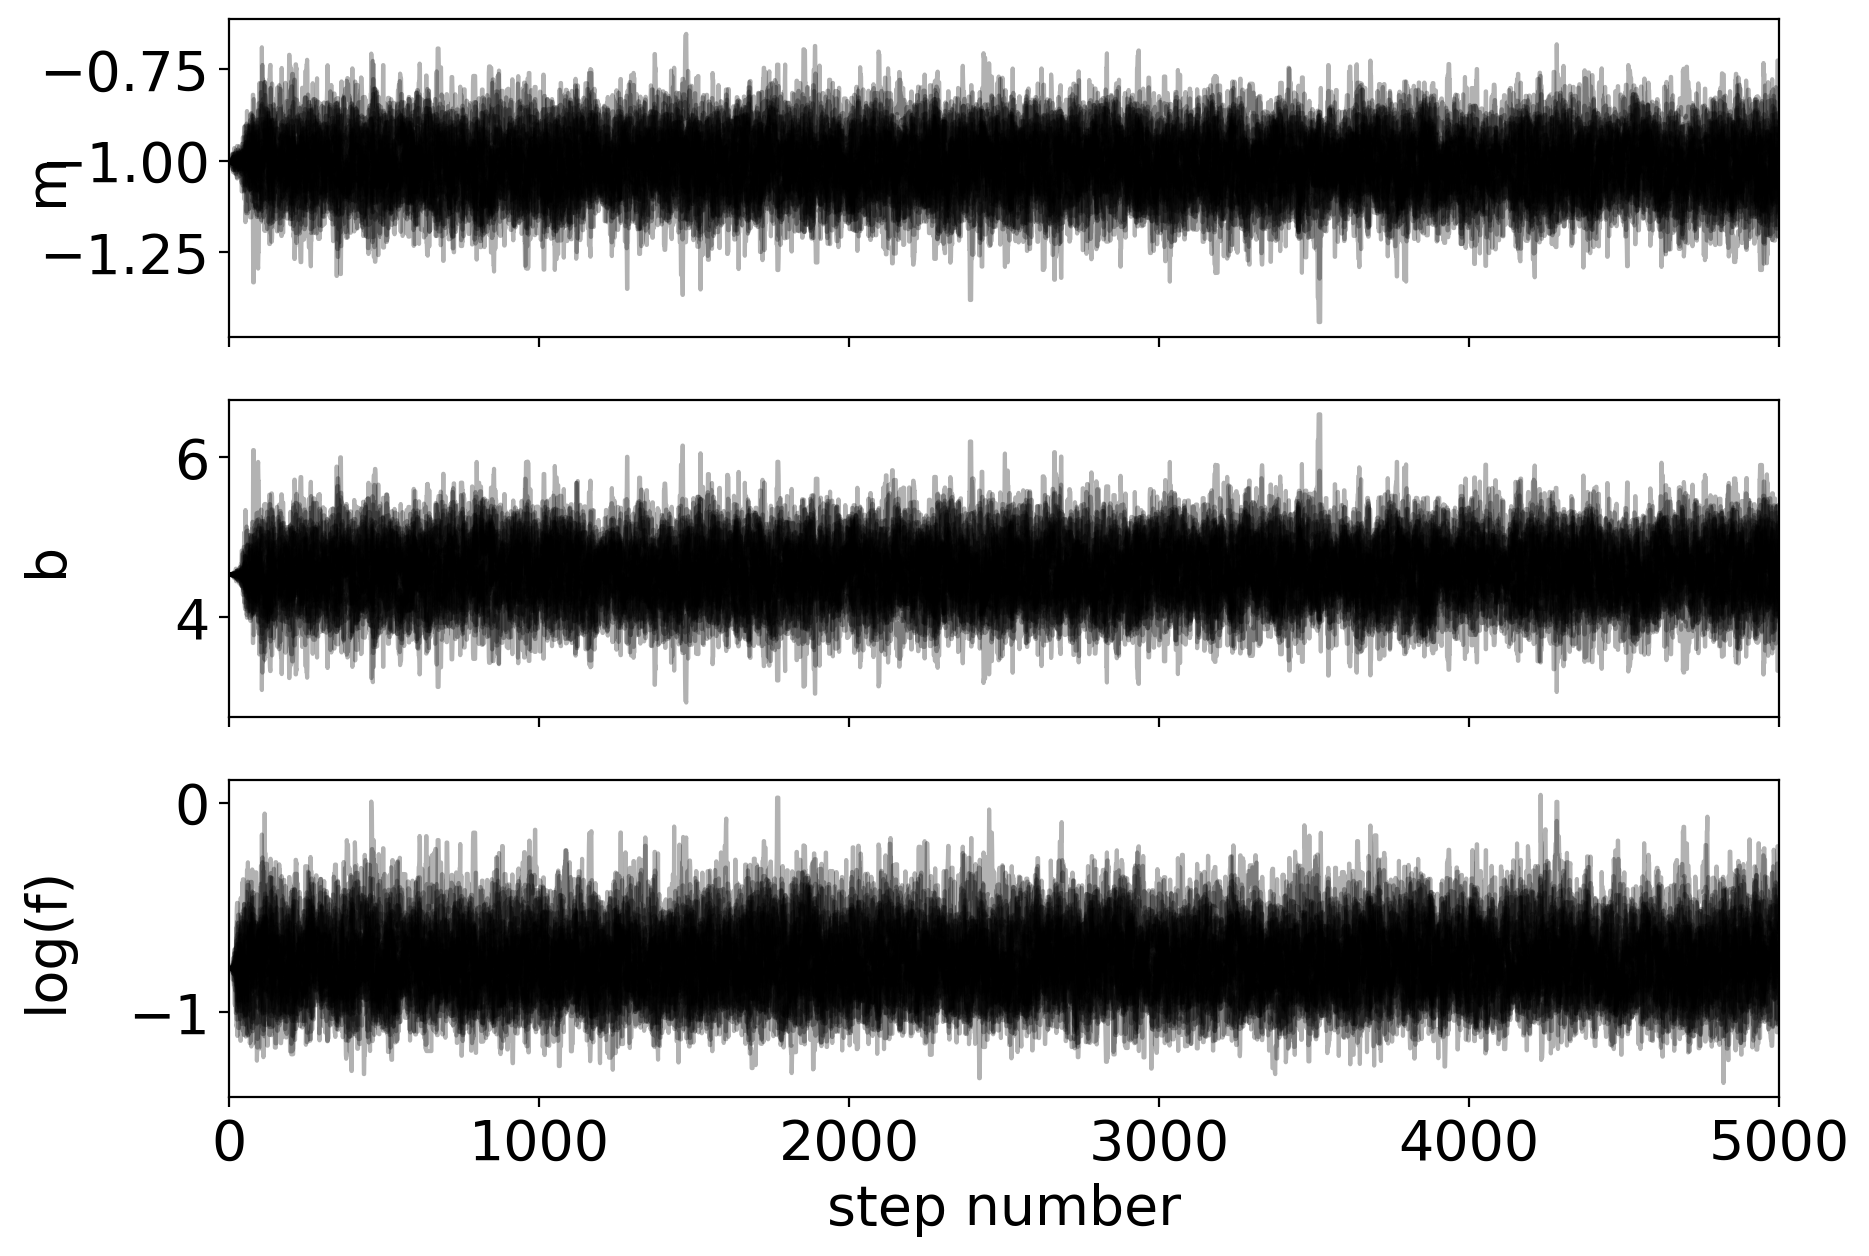

In [21]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Integrated autocorrelation time

IF samples are independent, then uncertainty $\sim \displaystyle{1\over\sqrt{N}}$.

However, Markov Chain samples are correlated! Uncertainty $\sim \displaystyle{\tau_f\over\sqrt{N}} > \displaystyle{1\over\sqrt{N}}$, where $\tau_f$ is the integrated autocorrelation time.

It can be thought as the number of steps taken for the chain to forget its initial state.

The autocorrelation time can be estimated using samples from the Markov Chain; however, enough samples are needed for accurate estimates of this quantity. The parallelisation of chains in the $\texttt{emcee}$ package means that convergence can be expected for chains longer than $\approx 50\tau$. In other words, **do not trust your estimate for $\tau_f$ if the number of samples in the chain used to estimate $\tau_f$ are less than $50\tau_f$**.

In [38]:
tau = sampler.get_autocorr_time()
print(f"Autocorrelation time estimated in three ways: {tau}")
samples = sampler.get_chain()
if samples.shape[0] < tau[0] * 50:
  print("Caution: Number of samples in chain fewer than 50 times the autocorrelation time!")
else:
  print("Number of samples in chain adequate for autocorrelation time estimate!")

Autocorrelation time estimated in three ways: [36.03979862 35.45827512 37.02933472]
Number of samples in chain adequate for autocorrelation time estimate!


To be safe, we will discard the first 3 * tau sxteps as burn-in.

We will then thin by half the autocorrelation time (i.e., we will only select every 15th sample).

Finally, we will flatten the chain to obtain a flat list of samples.

In [24]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [25]:
!pip install corner

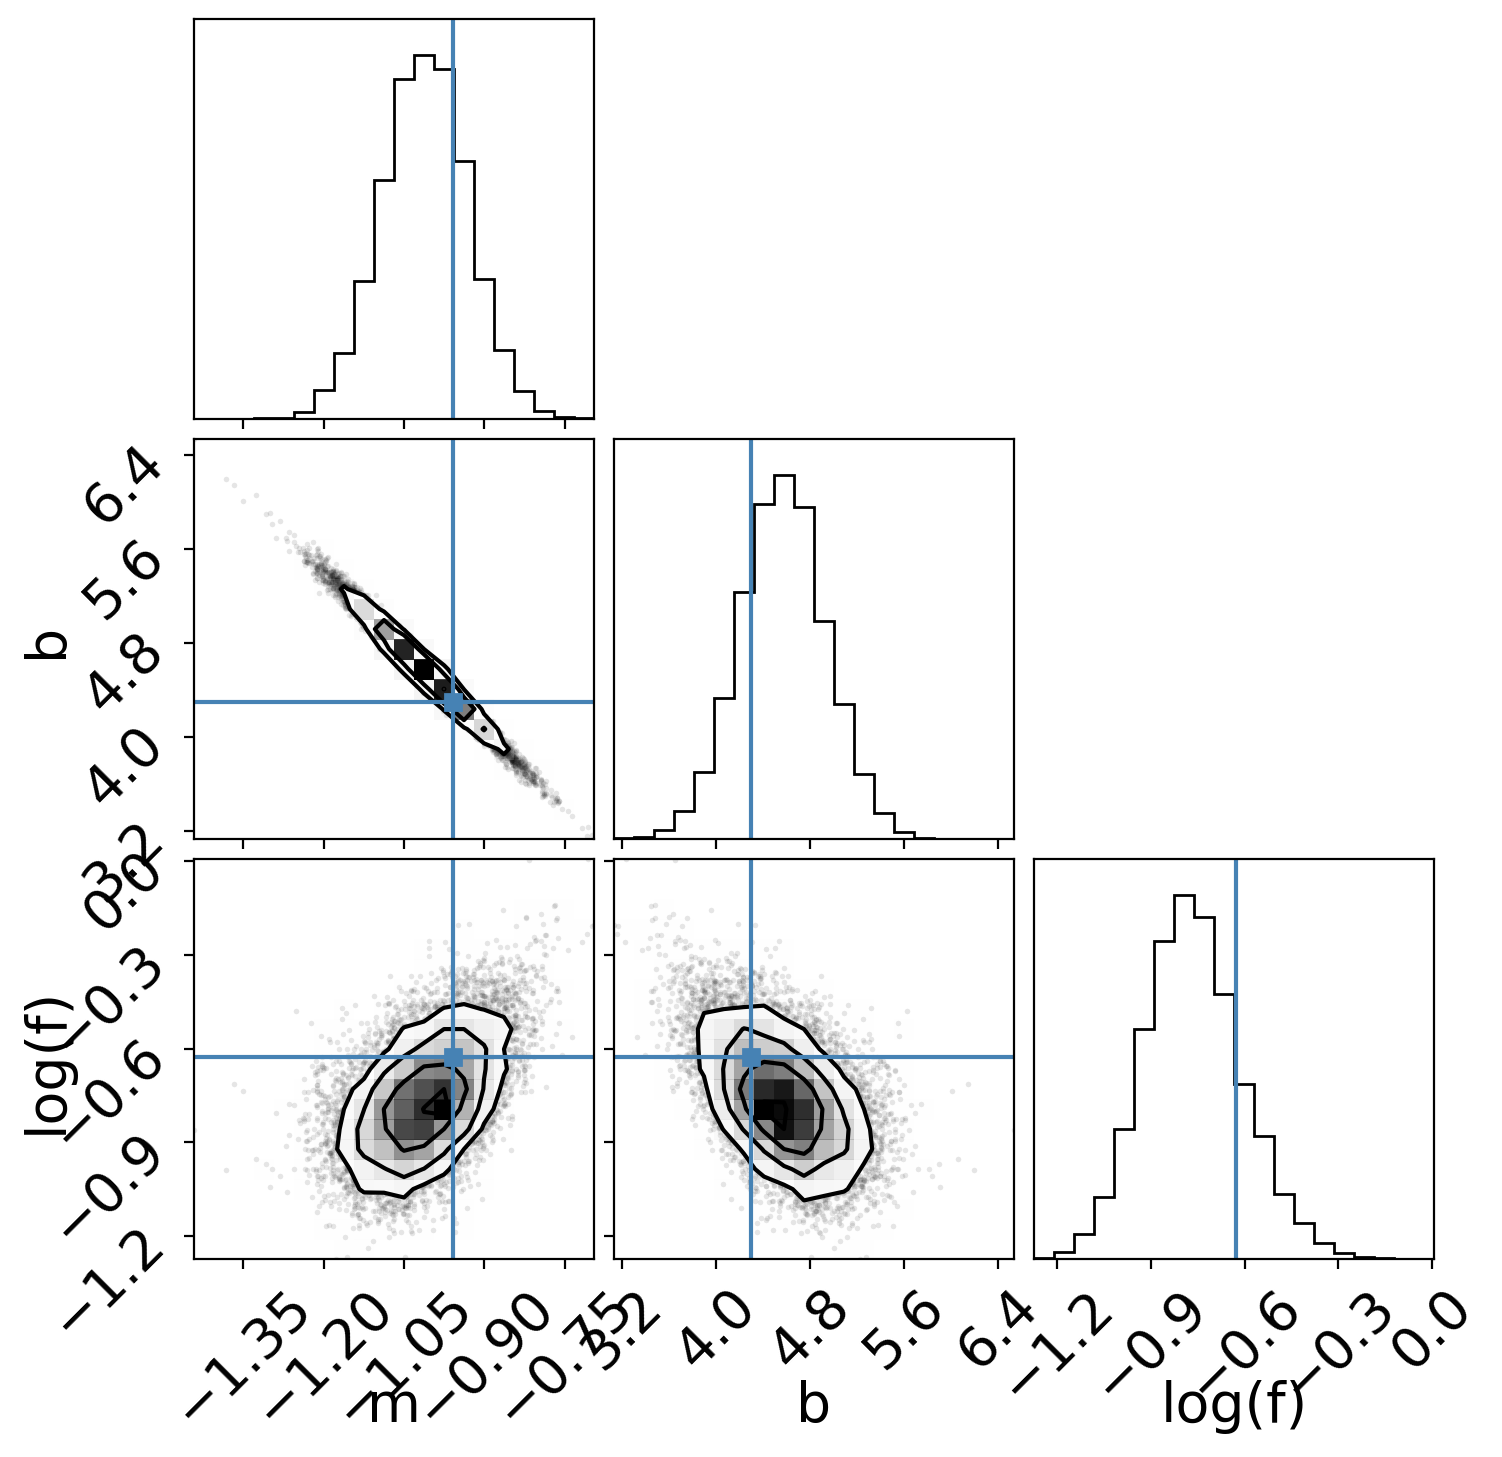

In [27]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

Note that the MAP values of the parameters do not coincide with their true values. This is one reason that we need to provide credible intervals!

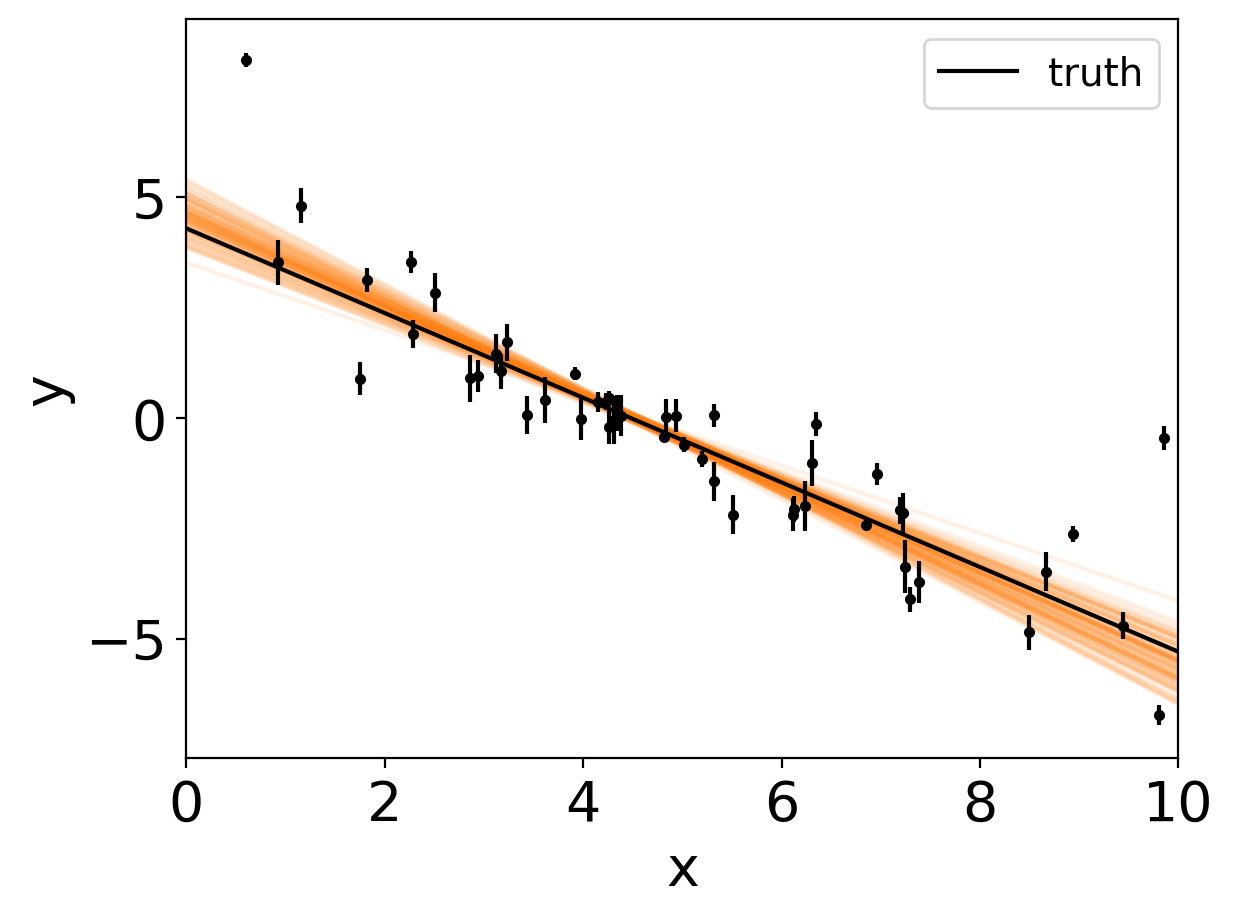

In [28]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Let's print out the median and the 68% credible interval for each parameter.

In [29]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>